
# Variance estimators (module ``variance_estimation``)

## Outline

Consider a particle estimate computed at time $t$ of a SMC algorithm: 
$$\mathbb{Q}_t^N(\varphi) = \sum_{n=1}^N W_t^n \varphi(X_t^n).$$

A basic way to evaluate its variability is to run the algorithm many times, and report the empirical variance. Which is of course expensive. (Note however that function ``multiSMC`` in the core module makes it possible to run SMC algorithms in parallel on multiple-core machines). 

Several recent papers (Chan and Lai, 2013; Lee and Whiteley, 2018; Olsson and Douc, 2019) have proposed estimators of the variance of a particle estimate that may be computed from a **single run**. These estimators require to track the genealogy of the particle system. In fact, the expression of these estimators is a variation of this: 
$$\sum_{n=1}^N \left[\sum_{m:B_t^m=n} W_t^m \left\{\varphi(X_t^m) - \mathbb{Q}_t^N(\varphi)\right\} \right]^2$$
where $B_t^n$ is the index of the ancestor of $X_t^n$ at time $0$ (the so-called **eve variables** in Lee and Whiteley, 2018). Note that this quantity **equals zero** as soon as all the particles have the same ancestor at time $0$. More generally, we expect these estimators to suffer from **path degeneracy** (i.e. number of distinct ancestors drops quicky.)


This notebook:

* explains how to compute such estimators, using module ``variance_estimators``;
* showcases their performance in a toy example.

## How to compute the available variance estimators

We start with the usual imports.

In [1]:
import itertools as it

from matplotlib import pyplot as plt
import numpy as np
from numpy import random
import pandas as pd
from scipy import stats
import seaborn as sb

import particles 
from particles import state_space_models as ssms
from particles import kalman  # Linear Gaussian state space models are defined here
from particles import collectors as col  # standard collectors

plt.style.use('ggplot')

We consider a basic univariate linear Gaussian model:

\begin{align*}
X_t & = \rho X_{t-1} + \sigma_X U_t \\
Y_t & = X_t + \sigma_Y V_t
\end{align*}
with $\rho=0.9$, $\sigma_X=1$, $\sigma_Y=0.2$. 

Data ($T=50)$ are simulated from the model. 

Let's run a single bootstrap filter, and have a look at the genealogical tree.

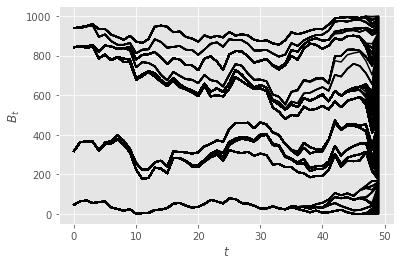

In [2]:
T = 50
ssm = kalman.LinearGauss(rho=0.9, sigmaX=1., sigmaY=0.2)
true_x, data = ssm.simulate(T)
fk = ssms.Bootstrap(ssm=ssm, data=data)
N = 1000
alg = particles.SMC(fk=fk, N=N, store_history=True) # store_history: keeps the complete history
alg.run()

B = alg.hist.compute_trajectories()

plt.figure()
for n in range(N):
    plt.plot(B[:, n], 'k')
plt.xlabel(r'$t$')
plt.ylabel(r'$B_t$');

The plot above represents the index of the ancestors of the final particles $X_T^n$, at times $t=0, ...,T$. Alternatively, we can plot the number of distinct ancestors (of particles $X_T^n$) at time $t$; see below. Clearly, although this is a toy example, and the number of time steps is quite small, we already observe some strong path degeneracy (although the number of ancestors at time 0 does not collapse to one).  

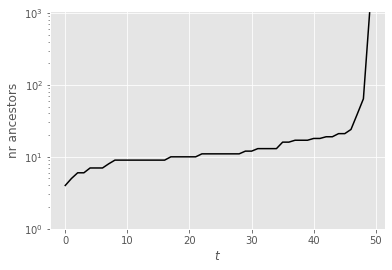

In [3]:
plt.figure()
plt.plot([np.unique(B[t, :]).shape[0] for t in range(T)], 'k')
plt.xlabel(r'$t$')
plt.ylabel('nr ancestors')
plt.ylim(bottom=1)
plt.yscale('log')

The block below shows how one may compute various variance estimators. These estimators are implemented as collectors (see module ``collectors``); i.e. as objects that compute and collect, at each time $t$, a certain variance estimator, and save the result in an an attribute of ``smc.summaries``, where ``smc`` is the considered ``SMC`` instance (the algorithm you are running). 

Variance estimators are implemented in a separated module, ``variance_estimators``. However, you don't need to import this module; you may invoke them as other collectors; that is, by adding the following key-words when calling ``SMC`` or ``multiSMC``:  
* ``var_est=phi``: computes the variance estimator of Chan and Lai (2013) for function ``phi``. 
* ``norm_cst_var_est=True``: compute the variance estimator of Lee and Whiteley (2018) for the normalising constant, $L_t$. 
* ``lag_based_var_est=phi``: compute the lag-based estimator of Olsson and Douc (2019) for function ``phi``. You must then specify a `maximum lag`, through the extra command ``store_history=max_lag``. See module ``smoothing`` for more details on storing the history of a SMC algorithm.

In [4]:
from particles import variance_estimators as ve

def phi(x):
    return x

max_lag = 11
nruns = 500 # 10_000 #yep!
runs = particles.multiSMC(fk=fk, N=N, resampling='multinomial',
                          collect=[col.Moments, ve.Var_logLt, 
                                   (ve.Var, {'phi': phi}), (ve.Lag_based_var, {'phi': phi})], 
                          store_history=max_lag, nruns=nruns, nprocs=0)

## Numerical results

We now use the results to assess the variability of the standard (not lag-based) variance estimator. To do so, we compare the empirical variance (over the $10^4$ runs) with the empirical distribution of the estimates (summarised by the median, $10\%-$ and $90\%-$ quantiles. 

We start with the normalising constants (i.e. the marginal likelihood of the data until time $t$). 

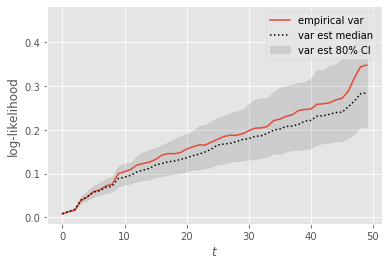

In [5]:
def plot_ci(time_range, arr):
    "Plot (empirical) confidence intervals."
    plt.plot(time_range, np.percentile(arr, 50, axis=0), 'k:', label='var est median')
    plt.fill_between(time_range, np.percentile(arr, 10, axis=0), np.percentile(arr, 90, axis=0), 
                     alpha=0.1, color='black', label='var est 80% CI')

plt.plot([np.var([r['output'].summaries.logLts[t] for r in runs]) for t in range(T)], label='empirical var')
ll_var_ests = np.array([r['output'].summaries.var_logLt for r in runs])
plot_ci(np.arange(T), ll_var_ests) # TODO no longer shifted by one! 
plt.xlabel(r'$t$')
plt.ylabel('log-likelihood')
plt.legend()

Not too bad, right? Note however that the error (in estimating the variance) seems to grow over time, and tends to be negative (under-estimation of the variance).

Let's now look at the performance of the variance estimators for function $\varphi(x)=x$; i.e. the variance of the particle estimates of the filtering expectations.

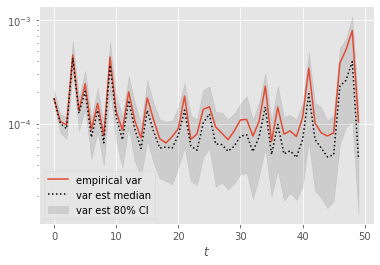

In [6]:
plt.figure()
ests =  np.array([[r['output'].summaries.moments[t]['mean'] for r in runs] for t in range(T)]).T
plt.plot(np.var(ests, axis=0), label='empirical var')
var_ests = np.array([r['output'].summaries.var for r in runs])
plot_ci(np.arange(T), var_ests)
plt.legend()
plt.xlabel(r'$t$')
plt.yscale('log')

Again, error seems to grow with time. Let's zoom on the first time steps:

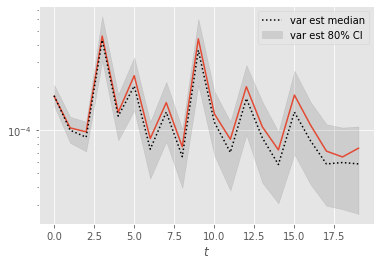

In [7]:
t0 = 20
plt.figure()
plt.plot(np.var(ests[:, :t0], axis=0))
plot_ci(np.arange(t0), var_ests[:, :t0])
plt.legend()
plt.xlabel(r'$t$')
plt.yscale('log')

At the first time steps, the variance estimates seem  more reliable, presumably because path degeneracy remains limited at times $\leq 20$.  

## Performance over repeated runs

I have been told that variance estimates may get more robust if averaged over repeated runs. To see if this is true, we bootstrap the sample of estimates to assess the performance over 10 runs.

In [8]:
# Bootstrap
nsample = 10
nboot = 10_000
boot_emp_var = np.zeros((nboot, T))
boot_var_ests = np.zeros((nboot, T))
for n in range(nboot):
    idx = random.choice(nruns, size=nsample, replace=False)
    boot_emp_var[n, :] = np.var(ests[idx, :], axis=0)
    boot_var_ests[n, :] = np.mean(var_ests[idx, :], axis=0)

The following plot compares the performance of:
* the empirical variance (of the considered estimate) over 10 runs;
* the empirical mean of the variance estimator over 10 runs.

Through averaging, the estimator becomes far more reliable, and seems to show comparable or better performance than the empirical variance. However, the level of improvement seems to decrease over time (again because of path degeneracy).

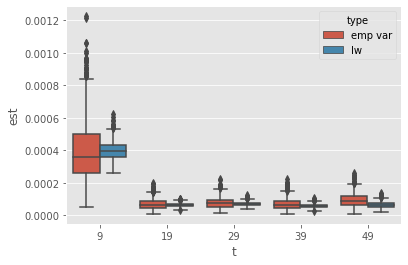

In [9]:
import itertools
d1 = [{'t': t, 'type': 'emp var', 'est': boot_emp_var[n, t]} for n, t in it.product(range(N), range(T))]
d2 = [{'t': t, 'type': 'lw', 'est': boot_var_ests[n, t]} for n, t in it.product(range(N), range(T))]
import pandas 
df = pandas.DataFrame(d1 + d2)
dft = df[df['t'] % 10 == 9 ]
sb.boxplot(x='t', y='est', hue='type', data=dft)

Thus, averaging does seem to help in making these estimators more robust (even at times where there is already strong path degeneracy).

## Lag-based estimators

Olsson and Douc (2019) proposed a variant of the CLLW estimators based on a lag approximation. This introduces a bias, but this also should alleviate the path degeneracy. 

We now look at the performance of OD estimators given the lag. 

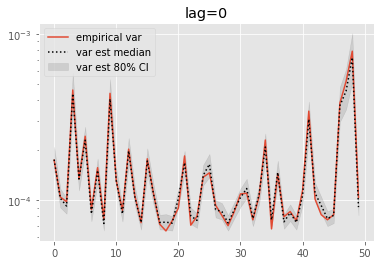

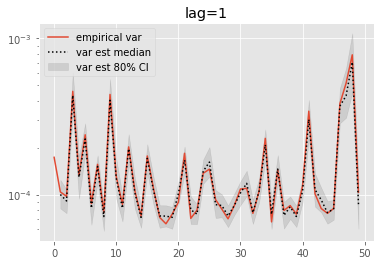

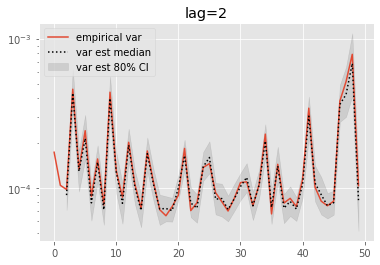

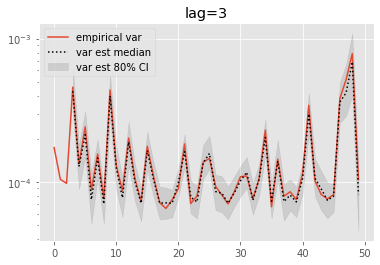

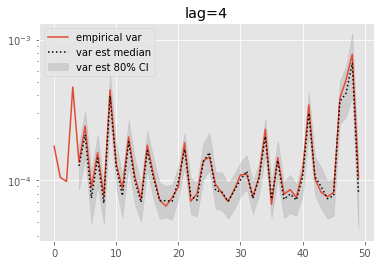

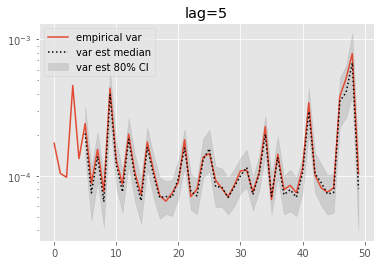

In [10]:
def get_list(l, k):
    if k < len(l):
        return l[k]
    else:
        return 0.
for lag in range(0, 6):
    plt.figure()
    plt.title('lag=%i' % lag)
    plt.plot(np.var(ests, axis=0), label='empirical var')
    times = list(range(lag, T))
    lag_var_ests = np.array([[get_list(est, lag) for est in r['output'].summaries.lag_based_var[lag:]] 
                            for r in runs])
    plot_ci(times, lag_var_ests)
    plt.legend()
    plt.yscale('log')

These results are a bit surprising: little bias is observed even for lag=0. Increasing the lag seems only to increase the error???  

## Bottom line

Based on these experiments (which are of course a bit limited), the following recommendations seem reasonable:
* Averaging over a small number of runs seems to make  variance estimators more robust.
* Even with averaging, the performance gain (relative to the empirical variance) may be modest as soon as the number of distinct eve variables is too small.
* When the number of distinct ever variables drop to one, these variance estimators do not work any more. 
* In that case, it may be worth switching to the lag-based variant of Olsson and Douc (2019). 
* However, choosing the value of the lag seems non-trivial, and deserves further investigation.

## References


* Chan, H.P. and Lai, T.L. (2013). A general theory of particle filters in
  hidden Markov models and some applications. Ann. Statist. 41, pp. 2877–2904.

* Lee, A and Whiteley, N (2018). Variance estimation in the particle filter.
  Biometrika 3, pp. 609-625.

* Olsson, J. and Douc, R. (2019). Numerically stable online estimation of
  variance in particle filters. Bernoulli 25.2, pp. 1504-1535.

# TODO

## here
* should we implement differently "external" collectors?
* does these estimate work only for multinomial resampling?
* which version, between CL and L&W?
* comment lags

## everywhere else
* document new collector interface 
* update book / notebooks